In [15]:
import os
from PIL import Image, ImageFile

# Enable loading of truncated images.
ImageFile.LOAD_TRUNCATED_IMAGES = True

def clean_directory(directory, valid_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
    """
    Walks through the directory and removes files that do not have a valid image extension
    or that are corrupted.
    """
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not file.lower().endswith(valid_extensions):
                print(f"Removing file (invalid extension): {file_path}")
                os.remove(file_path)
            else:
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verify that it is, in fact, an image.
                except Exception as e:
                    print(f"Removing corrupted file: {file_path} due to {e}")
                    os.remove(file_path)

# Clean the training and validation directories.
train_dir = './drive/MyDrive/data/train'
val_dir = './drive/MyDrive/data/validation'

clean_directory(train_dir)
clean_directory(val_dir)


Removing corrupted file: ./drive/MyDrive/data/train/okay/IMG_2285.JPG due to cannot identify image file './drive/MyDrive/data/train/okay/IMG_2285.JPG'
Removing corrupted file: ./drive/MyDrive/data/train/others/IMG_2289.JPG due to cannot identify image file './drive/MyDrive/data/train/others/IMG_2289.JPG'
Removing corrupted file: ./drive/MyDrive/data/train/others/IMG_2286.JPG due to cannot identify image file './drive/MyDrive/data/train/others/IMG_2286.JPG'
Removing corrupted file: ./drive/MyDrive/data/train/others/IMG_2290.JPG due to cannot identify image file './drive/MyDrive/data/train/others/IMG_2290.JPG'
Removing corrupted file: ./drive/MyDrive/data/train/others/IMG_2287.JPG due to cannot identify image file './drive/MyDrive/data/train/others/IMG_2287.JPG'


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

# Define dataset directories
train_dir = './drive/MyDrive/data/train'
val_dir = './drive/MyDrive/data/validation'

# Image dimensions and batch size
img_height, img_width = 224, 224  # MobileNetV2 typically uses 224x224
batch_size = 16  # Using a smaller batch size due to limited data

# Data augmentation for training; MobileNetV2 has its own preprocessing function.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation, we only apply the MobileNetV2 preprocessing.
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

print("Class Indices:", train_generator.class_indices)


Found 65 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Class Indices: {'okay': 0, 'others': 1}


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load MobileNetV2 with pre-trained ImageNet weights, exclude the top layers.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model so that its weights are not updated during the first phase of training.
base_model.trainable = False

# Build the model on top of the base model.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
x = Dense(128, activation='relu')(x)
# Output layer: single neuron for binary classification using sigmoid.
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3785 - loss: 1.2963
Epoch 1: val_loss improved from inf to 0.84232, saving model to best_transfer_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 9s/step - accuracy: 0.4000 - loss: 1.2456 - val_accuracy: 0.5610 - val_loss: 0.8423 - learning_rate: 0.0010
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6803 - loss: 0.6120
Epoch 2: val_loss improved from 0.84232 to 0.76171, saving model to best_transfer_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6798 - loss: 0.6145 - val_accuracy: 0.5366 - val_loss: 0.7617 - learning_rate: 0.0010
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6936 - loss: 0.5377
Epoch 3: val_loss did not improve from 0.76171
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6985 - loss: 0.5264 - val_accuracy: 0.5610 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8148 - loss: 0.3845
Epoch 4: val_loss did not improve from 0.76171

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8046 - loss: 0.4055 - val_accuracy: 0.5366 - val_loss: 0.8749 - learning_rate: 0.0010
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9193 - loss: 0.2981
Epoch 5: val_loss did not improve from 0.76171
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9123 - loss: 0.3033 - val_accuracy: 0.5610 - val_loss: 0.8218 - learning_rat

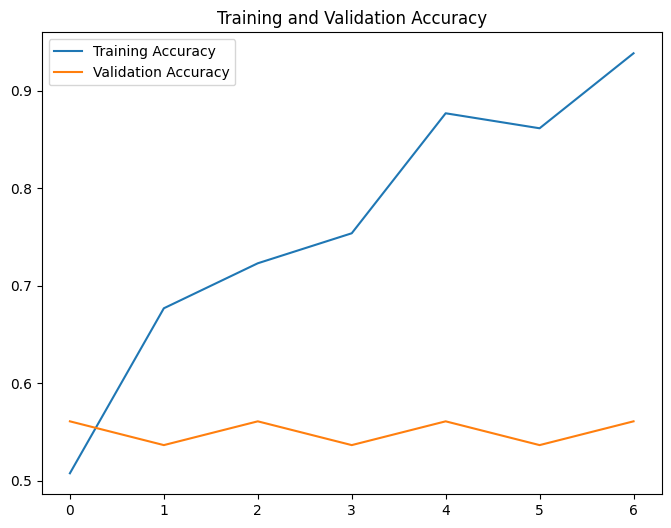

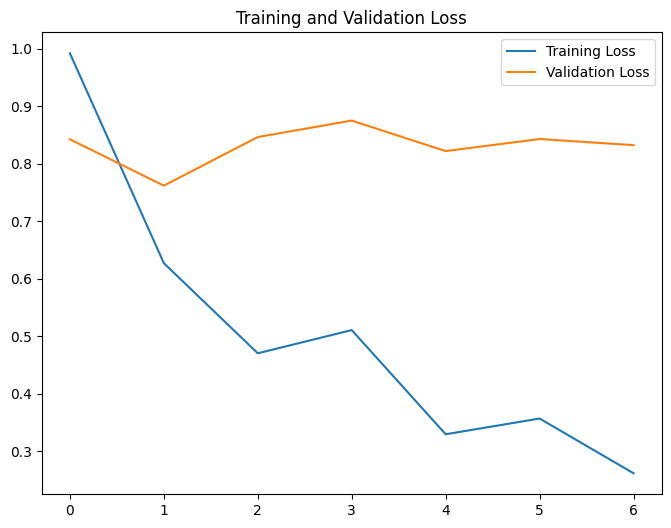

In [3]:
# Callbacks for better training control.
checkpoint_path = 'best_transfer_model.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Train the model. Increase epochs as needed.
initial_epochs = 30
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=validation_generator,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,019,201 (7.70 MB)

 Non-trainable params: 402,880 (1.54 MB)

Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6158 - loss: 0.7232
Epoch 7: val_loss improved from 0.76171 to 0.76076, saving model to best_transfer_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.6157 - loss: 0.7250 - val_accuracy: 0.5610 - val_loss: 0.7608 - learning_rate: 1.0000e-05
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6637 - loss: 0.6730
Epoch 8: val_loss did not improve from 0.76076
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6762 - loss: 0.6608 - val_accuracy: 0.5610 - val_loss: 0.7622 - learning_rate: 1.0000e-05
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5228 - loss: 0.6878
Epoch 9: val_loss did not improve from 0.76076

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5460 - loss: 0.6746 - val_accuracy: 0.5610 - val_loss: 0.7628 - learning_rate: 1.0000e-05
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7583 - loss: 0.5516
Epoch 10: val_loss did not improve from 0.76076
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7524 - loss: 0.5476 - val_accuracy: 0.5610 - val_loss: 0.7635 

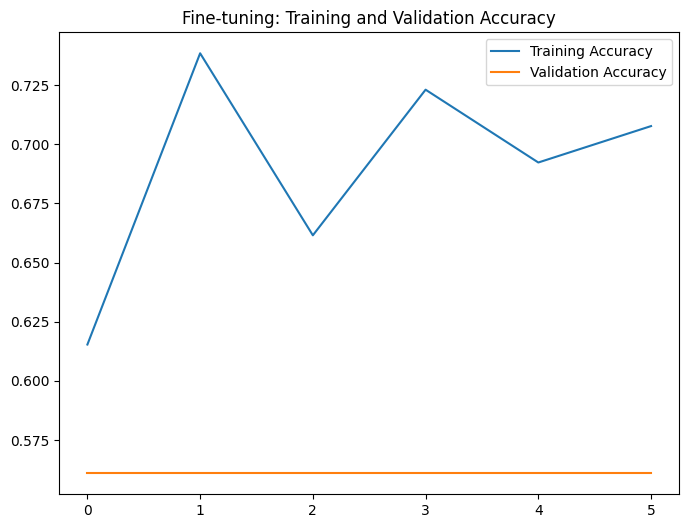

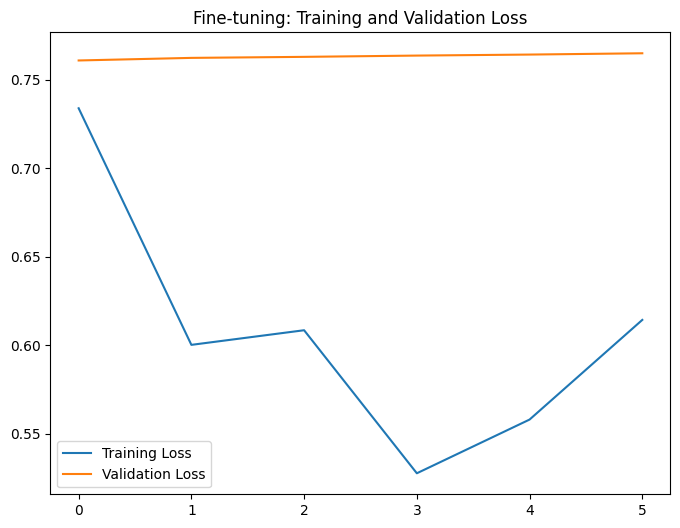

In [4]:
# Unfreeze some layers of the base model for fine-tuning.
# For example, unfreeze the last 50 layers.
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with a lower learning rate.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Fine-tune for additional epochs.
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

# Plot the fine-tuning training history.
plt.figure(figsize=(8, 6))
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuning: Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Fine-tuning: Training and Validation Loss')
plt.legend()
plt.show()


In [9]:
import io
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np

def predict_image_from_bytes(image_bytes):
    # Load and preprocess the image
    img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    # Preprocess using MobileNetV2's preprocessing function
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_value = pred[0][0]

    # If 'okay' is label 0 (assuming alphabetical ordering with folders)
    if pred_value < 0.5:
        return "okay", pred_value
    else:
        return "others", pred_value

# Create interactive widgets
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
button = widgets.Button(description="Predict Gesture")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        if len(upload_widget.value) == 0:
            print("Please upload an image.")
        else:
            for fname, file_info in upload_widget.value.items():
                print("Predicting for:", fname)
                label, pred_value = predict_image_from_bytes(file_info['content'])
                print("Prediction:", label, f"(raw value: {pred_value:.4f})")
                display(Image.open(io.BytesIO(file_info['content'])))

button.on_click(on_button_clicked)

display(upload_widget, button, output)


FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Predict Gesture', style=ButtonStyle())

Output()